In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from shapely import geometry
import libpysal

In [2]:
# read the data
pop = gpd.read_file('/Users/xqy/Desktop/Ghent/CPoPGrid.gpkg')
green = gpd.read_file('/Users/xqy/Desktop/Ghent/PublicGreenspaces.gpkg')
boundry= gpd.read_file('/Users/xqy/Desktop/Ghent/city_bound_clip.shp')

In [3]:
place_name = "Ghent, Belgium"
G = ox.graph_from_place(place_name, network_type='all', buffer_dist = 1600)
G_proj = ox.project_graph(G,to_crs='epsg:32631')
G_nodes_proj, G_edges_proj = ox.graph_to_gdfs(G_proj, nodes=True, edges=True)
edges = G_edges_proj.unary_union

/opt/miniconda3/envs/ssml/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [5]:
def green_data_prepocessing(green,boundry,buffer, destination = 'centroids'):
    """
    green space data preprocessing:
    green is the green space geodataframe;
    boundry is the city's administrative boundry;
    destination represents the fake gate of green space, 'centroids' means using centroids of 
    green space as access point. 'Entrance' means using the intersections points;
    buffer is added around the green space to do the intersection with road network, usually 20m

    """
     
    # transfer the CRS
    boundry = boundry.to_crs(epsg = 32631) 
    green =  green.to_crs(epsg = 32631)
    
    # clip green space within the buffered city boundry
    # first to add a buffer around the boundry to ensure people 
    # live around the edge of the boundry could access the green space outside the city but still within distance threshold
    boundry_buffer = boundry.buffer(buffer)
    green_clip = green.clip(boundry_buffer,keep_geom_type=False)
    
    # merge the overlap green space into one polygon
    s_ = gpd.GeoDataFrame(geometry=[green_clip.unary_union]).explode(
        index_parts=False).reset_index(drop=True).set_crs(epsg = 32631)
    s_ = gpd.sjoin(s_, green_clip, how='left').drop(columns=['index_right'])
    green_dis = s_.dissolve(s_.index, aggfunc='first')
    # reset the index 
    green_dis =green_dis.reset_index(drop=True)
    #create the buffer of green space, ususally 20m, prepare for intersetion to get the accesses
    green_dis['buffer_20m'] = green_dis['geometry'].buffer(20)
    
    # define the green areas that overlap with each other within 20m as the same component
    W = libpysal.weights.fuzzy_contiguity(green_dis['buffer_20m'])
    green_dis['green_components']= W.component_labels
    green_space = green_dis.dissolve('green_components')

    
    #create the centroid of the green space
    green_space['centroids'] = green_space['geometry'].centroid
    #calculate the area of the green space
    green_space['area'] = green_space['geometry'].area
    # select area >400m2
    green_space = green_space[green_space['area'] > 400]
    green_space = green_space.reset_index(drop=True)
    
    entrance = []  
    # choose different fake gate model
    # use centroid of green space 
    if destination == 'centroids':
        green_access = green_space[['centroids','area']]
        green_access.rename(columns = {'centroids': 'geometry'}, inplace = True)
        green_access['park_id'] = list(range(len(green_space)))
        
    
    # use the intersection points: the road network and buffered green space polygon
    elif destination == 'Entrance':
        # add the buffer of 20m for each components
        green_space['buffer'] = green_space['geometry'].buffer(20)
        for i in range(len(green_space)):
            green_area = green_space.loc[i,'geometry'].area
            intersection = green_space['buffer'][i].boundary.intersection(edges)
            try:
                for point in intersection:
                    dic = {'geometry': point, 'area': green_area, 'park_id': i}
                    entrance.append(dic)
            except: continue
    green_access = gpd.GeoDataFrame(entrance)
    # if the distance of two fake entrances is less than 50m, then keep the first entrance
    green_access['buffer'] = green_access['geometry'].buffer(25)
    w_e = libpysal.weights.fuzzy_contiguity(green_access['buffer'])
    green_access['entrance_components']= w_e.component_labels
    # Delete duplicate rows based on specific columns 
    green_access =  green_access.drop_duplicates(subset=["entrance_components"], keep='first')
    green_access = green_access.reset_index(drop=True)
    
    return green_access    

In [6]:
green_access  = green_data_prepocessing(green,boundry,1600, destination = 'Entrance')

/opt/miniconda3/envs/ssml/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 131 disconnected components.
 There are 84 islands with ids: 3, 4, 5, 7, 9, 11, 16, 17, 20, 27, 35, 41, 42, 43, 44, 45, 46, 53, 54, 58, 62, 63, 64, 65, 66, 67, 84, 89, 96, 122, 129, 130, 131, 132, 133, 139, 142, 143, 151, 152, 153, 157, 158, 161, 162, 163, 164, 168, 174, 186, 189, 192, 193, 198, 199, 200, 206, 211, 212, 213, 214, 216, 218, 219, 220, 221, 222, 223, 224, 226, 227, 228, 234, 242, 243, 245, 247, 248, 249, 253, 257, 258, 259, 260.
  warnings.warn(message)
/var/folders/dz/g4g1wlbx68j6lf5ynsmx9nmm0000gn/T/ipykernel_94642/2658674458.py:63: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for point in intersection:
/opt/miniconda3/envs/ssml/lib/python3.9/site-packages/libpysal/w

In [8]:
green_access.head()

,geometry,area,park_id,buffer,entrance_components
0,POINT (545778.579 5651685.560),341806.765202,0,"POLYGON ((545803.579 5651685.560, 545803.459 5...",0
1,POINT (545836.715 5651432.938),341806.765202,0,"POLYGON ((545861.715 5651432.938, 545861.595 5...",1
2,POINT (545856.239 5651357.635),341806.765202,0,"POLYGON ((545881.239 5651357.635, 545881.119 5...",2
3,POINT (546362.537 5651298.205),341806.765202,0,"POLYGON ((546387.537 5651298.205, 546387.417 5...",3
4,POINT (546300.898 5651163.646),341806.765202,0,"POLYGON ((546325.898 5651163.646, 546325.778 5...",4


In [10]:
def population_data_prepocessing(pop,boundry,distance_threshold):
    
    """
    population data prepocessing:
    pop is the population geodataframe;
    boundry is the city's administrative boundry; 
    distance_threshold is the walking or driving distance; 
    
    """
    
    # transfer the CRS
    boundry = boundry.to_crs(epsg = 32631) 
    pop =  pop.to_crs(epsg = 32631)
    
    # clip population within the city boundry
    pop_clip = pop.clip(boundry,keep_geom_type=False)

    # remove places with 0 population
    pop_remove0 = pop_clip[(pop_clip['PoP2015_Number'] == 0) == False]
    pop_remove0['area'] = pop_remove0['geometry'].area
    
    # remove boundry population if the area of grid cell is less than half of the regular area
    pop_remove_bound = pop_remove0[pop_remove0['area'] > pop_remove0['area'].max()*0.5]
    
    #create the centroid of the population grid cell
    pop_remove_bound['centroids'] = pop_remove_bound['geometry'].centroid
    #create the buffer of each grid cell, which equals the distance threshold
    pop_remove_bound['buffer'] = pop_remove_bound['geometry'].buffer(distance_threshold)
    # reset the index 
    pop_remove_bound  = pop_remove_bound.reset_index(drop=True)
    
    return pop_remove_bound

In [11]:
pop_remove_bound = population_data_prepocessing(pop,boundry,1600)

/opt/miniconda3/envs/ssml/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/miniconda3/envs/ssml/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/miniconda3/envs/ssml/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [13]:
pop_remove_bound.head()

,grid_id,PoP2015_Number,geometry,area,centroids,buffer
0,14637,32,"POLYGON ((547775.017 5650154.289, 547776.473 5...",19285.259008,POINT (547711.985 5650084.071),"POLYGON ((547760.265 5651754.221, 547917.156 5..."
1,14523,36,"POLYGON ((547773.562 5650311.867, 547775.017 5...",24832.952377,POINT (547695.501 5650232.351),"POLYGON ((547758.810 5651911.799, 547915.700 5..."
2,14867,45,"POLYGON ((548093.108 5649842.039, 548094.322 5...",14405.552053,POINT (548025.693 5649793.068),"POLYGON ((547392.136 5648275.690, 547391.910 5..."
3,14984,45,"POLYGON ((548567.358 5649688.863, 548568.837 5...",21251.497248,POINT (548495.251 5649619.553),"POLYGON ((548552.363 5651288.793, 548709.254 5..."
4,14985,44,"POLYGON ((548724.952 5649690.345, 548726.437 5...",24839.060506,POINT (548646.896 5649610.805),"POLYGON ((548709.909 5651290.274, 548866.800 5..."


In [14]:
def get_the_index_within_dist(pop_clip,green_access ):
    
    """
    this step is to create a dataframe with pairs of population grid cell and green space
    whose euclidian distance is smaller than distance threshold
    
    """
  
    k= []
    for i in range(len(pop_clip)):
        for j in range(len(green_access)):
            if green_access['geometry'][j].within(pop_clip['buffer'][i]):
            #distance. = pop_clip['centroids'][i].distance(access_point['geometry'][j])
                index = {'pop_index': i, 'green_index': j,
                         'green_area': green_access['area'][j],
                         'park_id': green_access['park_id'][j],
                         'pop_num': pop_clip.loc[i, 'PoP2015_Number']}
                k.append(index)
    df_index = pd.DataFrame(k)
    return df_index

In [15]:
df_index = get_the_index_within_dist(pop_remove_bound,green_access)

In [17]:
df_index.head()

,pop_index,green_index,green_area,park_id,pop_num
0,1,3,341806.765202,0,36
1,1,4,341806.765202,0,36
2,1,16,341806.765202,0,36
3,2,255,150518.426682,22,45
4,2,256,150518.426682,22,45


In [18]:
def origin_node(df_index,pop_clip):
    # get the unique value of pop index
    pop_unique = df_index['pop_index'].unique()
    
    orig_id = []
    # get the nearest node id of each centroid of population grid cell
    for i in range(len(pop_unique)):
        pop_index = pop_unique[i]
        orig_node = ox.distance.nearest_nodes(G_proj,pop_clip.loc[pop_index,'centroids'].x,
                                                pop_clip.loc[pop_index,'centroids'].y)
        dic = {'pop_index':pop_unique[i],'orig_node':orig_node}
        orig_id.append(dic)
    orig_id_df = pd.DataFrame(orig_id)
    return orig_id_df

In [19]:
orig_id_df = origin_node(df_index,pop_remove_bound)

In [21]:
orig_id_df.head()

,pop_index,orig_node
0,1,496263233
1,2,367220694
2,3,8000349524
3,4,475413667
4,5,1878074612


In [25]:
def target_node(df_index, green_access):
    # get the unique value of green index
    green_unique = df_index['green_index'].unique()
    target_id = []
    # get the nearest node id of each green space
    for i in range(len(green_unique)):
        green_index = green_unique[i]
        target_node = ox.distance.nearest_nodes(G_proj,green_access.loc[green_index,'geometry'].x,
                                                green_access.loc[green_index,'geometry'].y)
        dic = {'green_index':green_unique[i],'target_node': target_node}
        target_id.append(dic)
    target_id_df = pd.DataFrame(target_id)
    return target_id_df

In [26]:
target_id_df =  target_node(df_index, green_access)

In [27]:
target_id_df 

,green_index,target_node
0,3,2620347574
1,4,2620364350
2,16,3962091331
3,255,8097092419
4,256,8097092418
...,...,...
788,792,1709350541
789,781,6122792104
790,784,3495021550
791,782,449076142


In [28]:
pop_merge = pd.merge(df_index, orig_id_df, how = 'left', on = 'pop_index' )
pop_merge.head()

,pop_index,green_index,green_area,park_id,pop_num,orig_node
0,1,3,341806.765202,0,36,496263233
1,1,4,341806.765202,0,36,496263233
2,1,16,341806.765202,0,36,496263233
3,2,255,150518.426682,22,45,367220694
4,2,256,150518.426682,22,45,367220694


In [29]:
merge = pd.merge(pop_merge, target_id_df, how = 'left', on = 'green_index' )
merge.head()

,pop_index,green_index,green_area,park_id,pop_num,orig_node,target_node
0,1,3,341806.765202,0,36,496263233,2620347574
1,1,4,341806.765202,0,36,496263233,2620364350
2,1,16,341806.765202,0,36,496263233,3962091331
3,2,255,150518.426682,22,45,367220694,8097092419
4,2,256,150518.426682,22,45,367220694,8097092418


In [31]:
def OD_Matrix(merge):
    """
    get the real distance between each pair of population grid cell and green space 
    """
    distance = []
    for i in range(len(merge)):
        try: 
            orig_node = merge.loc[i, 'orig_node']
            target_node = merge.loc[i, 'target_node']
            dist = nx.shortest_path_length(G_proj, source=orig_node, 
                                           target=target_node, weight='length')
            distance.append(dist)
        except:
            distance.append(np.nan)
    merge['distance'] = distance
    return merge

In [32]:
merge_dist = OD_Matrix(merge)

In [33]:
merge_dist

,pop_index,green_index,green_area,park_id,pop_num,orig_node,target_node,distance
0,1,3,341806.765202,0,36,496263233,2620347574,1856.836
1,1,4,341806.765202,0,36,496263233,2620364350,2182.466
2,1,16,341806.765202,0,36,496263233,3962091331,2201.193
3,2,255,150518.426682,22,45,367220694,8097092419,2155.679
4,2,256,150518.426682,22,45,367220694,8097092418,2127.709
...,...,...,...,...,...,...,...,...
260465,5852,782,50037.522341,129,64,1727283360,449076142,2108.563
260466,5852,783,50037.522341,129,64,1727283360,449076142,2108.563
260467,5853,783,50037.522341,129,14,1727283360,449076142,2108.563
260468,5855,783,50037.522341,129,75,1727283360,449076142,2108.563


In [34]:
OD_mile = merge_dist[merge_dist['distance'] < 1600]

In [38]:
OD_mile = OD_mile.reset_index(drop=True)

In [39]:
OD_mile 

,pop_index,green_index,green_area,park_id,pop_num,orig_node,target_node,distance
0,3,256,150518.426682,22,45,8000349524,8097092418,1599.359
1,3,257,9757.063733,23,45,8000349524,738929379,1591.564
2,3,258,9757.063733,23,45,8000349524,1605813547,1582.428
3,3,259,9757.063733,23,45,8000349524,1605813521,1496.832
4,4,255,150518.426682,22,44,475413667,8097092419,1423.331
...,...,...,...,...,...,...,...,...
113953,5839,783,50037.522341,129,50,1644207781,449076142,1379.740
113954,5839,784,50037.522341,129,50,1644207781,3495021550,1390.962
113955,5842,782,50037.522341,129,73,1644207781,449076142,1379.740
113956,5842,783,50037.522341,129,73,1644207781,449076142,1379.740


In [49]:
# this function is for the entrance model
# if the entrances are belong to the same park, I will choose the nearest entrance. 
def neareat_entrance(OD_mile): # OD_mile is the OD Matrix after selection, e.g real_distance < 1km
    unique = OD_mile['pop_index'].unique()
    OD_nearest_E = []
    for i in a:
        df = OD_mile.loc[OD_mile['pop_index'] == i]
        df1 = df.groupby('park_id').min('distance')
        for j in df1.index:
            dic = {'pop_index': i,'park_id': j,'distance':df1.loc[j,'distance'],
              'green_area': df1.loc[j,'green_area'], 'pop_num':df1.loc[j,'pop_num']}
            OD_nearest_E.append(dic)
    OD_nearest_E = pd.DataFrame(OD_nearest_E)
    return OD_nearest_E

In [53]:
OD_nearest_E

,pop_index,park_id,distance,green_area,pop_num
0,3,22,1599.359,150518.426682,45
1,3,23,1496.832,9757.063733,45
2,4,22,1395.361,150518.426682,44
3,4,23,1292.834,9757.063733,44
4,4,24,1572.975,17032.717459,44
...,...,...,...,...,...
24242,5819,129,1527.766,50037.522341,32
24243,5820,129,1489.007,50037.522341,74
24244,5821,129,1527.766,50037.522341,79
24245,5839,129,1379.740,50037.522341,50


In [ ]:
# modified two-step floating catchment area model

def M2tsfca (OD_nearest_E):
    
    # use gussian distribution: let v= 923325, then the weight for 800m is 0.5
    # add a column of weight: apply the decay function on distance
    OD_nearest_E['weight'] = np.exp(-(OD_nearest_E['distance'])**2/923325).astype(float) 
    OD_nearest_E['weighted_pop'] = OD_nearest_E['weight'] * OD_nearest_E['pop_num']

    # get the sum of weighted population each green space has to serve.
    s_w_p = pd.DataFrame(OD_nearest_E.groupby('park_id').sum('weighted_pop')['weighted_pop'])
    # delete other columns, because they are useless after groupby
    s_w_p = s_w_p.rename({'weighted_pop':'sum_weighted_pop'},axis = 1)
    middle = pd.merge(OD_nearest_E,s_w_p, how = 'left', on = 'park_id' )
    # calculate the supply-demand ratio for each green space
    middle['green_supply'] = middle['green_area']/middle['sum_weighted_pop']
    
    # caculate the accessbility score for each green space that each population grid cell could reach
    middle['access_score'] = middle['weight'] * middle['green_supply']
    # add the scores for each population grid cell
    pop_score_df = pd.DataFrame(middle.groupby('pop_index').sum('access_score')['access_score'])

    # calculate the mean distance of all the green space each population grid cell could reach
    mean_dist = middle.groupby('pop_index').mean('distance')['distance']
    pop_score_df['mean_dist'] = mean_dist

    # calculate the mean area of all the green space each population grid cell could reach
    mean_area = middle.groupby('pop_index').mean('green_area')['green_area']
    pop_score_df['mean_area'] = mean_area

    # calculate the mean supply_demand ratio of all the green space each population grid cell could reach
    mean_supply = middle.groupby('pop_index').mean('green_supply')['green_supply']
    pop_score_df['mean_supply'] = mean_supply

    return pop_score_df

In [81]:
pop_score_df = M2tsfca (OD_nearest_E)

In [98]:
pop_score_df

,access_score,mean_dist,mean_area,mean_supply
pop_index,,,,
3,3.364714,1548.0955,80137.745208,26.509929
4,6.667963,1420.3900,59102.735958,18.451243
13,0.108090,1594.4480,9757.063733,1.696535
17,0.479411,1412.0830,13394.890596,2.015202
18,0.108090,1594.4480,9757.063733,1.696535
...,...,...,...,...
5819,0.915389,1527.7660,50037.522341,11.467187
5820,1.038972,1489.0070,50037.522341,11.467187
5821,0.915389,1527.7660,50037.522341,11.467187


In [101]:
pop_remove_bound['pop_index'] = list(range(len(pop_remove_bound)))

In [103]:
final_acc_score = pd.merge(pop_remove_bound, pop_score_df, how = 'left', on='pop_index')

In [105]:
final_acc_score = final[['PoP2015_Number','geometry','access_score','mean_dist','mean_area','mean_supply']]

<AxesSubplot:>

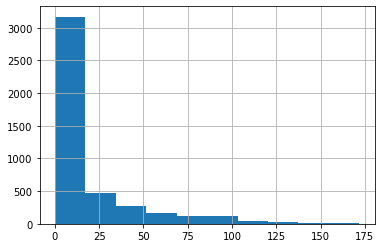

In [113]:
final_acc_score['access_score'].hist()